# Test models and see performance

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from argparse import ArgumentParser
import yaml
from typing import Dict, Tuple, Union, Any
import pickle
from pathlib import Path
import os
import matplotlib.pyplot as plt
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent
sys.path.insert(0, str(base_dir))
from models import MODELS

In [84]:
# Load config file

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

In [85]:
def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = '../' + config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]

    if config['Model']['name'] == 'RF':
      # Add derivatives
      derivatives = X.diff(axis=1)
      for col in X.columns[1:]:
          X[col + '_derivative'] = derivatives[col]
      # Add NDVI
      X['ndvi'] = (X['B08'] - X['B04'])/(X['B08'] + X['B04'])

    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
      #X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=config['Data']['test_size'], random_state=config['Seed'])
      #print('here')
      #return X_test, y_test
    else:
      return X, y.values

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    X = concatenated_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = concatenated_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]

    if config['Model']['name'] == 'RF':
      # Add derivatives
      derivatives = X.diff(axis=1)
      for col in X.columns[1:]:
          X[col + '_derivative'] = derivatives[col]
      # Add NDVI
      X['ndvi'] = (X['B08'] - X['B04'])/(X['B08'] + X['B04'])
      
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
    else:
      return X, y.values

  else:
      return None

X_test, y_test = prepare_data(config)

In [86]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  model.test_scores(y_test=y_test, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X_test)
  model.test_scores(y_test=y_test, y_pred=y_pred)

Test RMSE: 2.803563503430657


In [87]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

-3.9216919322951203

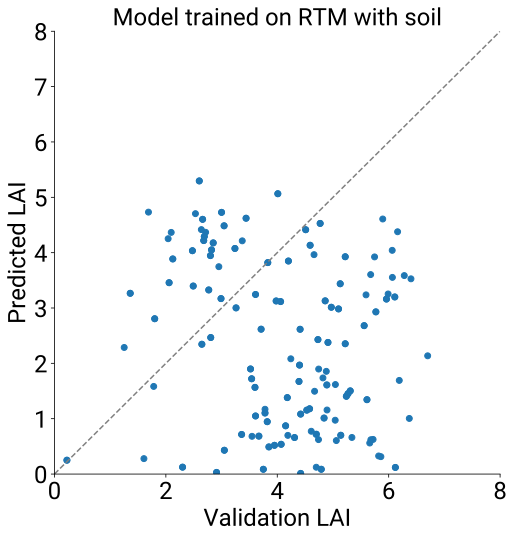

In [88]:
# Plot ypred vs ytest

# Define font sizes
SIZE_DEFAULT = 20
SIZE_LARGE = 24
plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_LARGE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_LARGE)  # fontsize of the tick labels

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y_test, y_pred)
ax.set_xlabel('Validation LAI')
ax.set_ylabel('Predicted LAI')
#ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
ax.set_title(f'Model trained on RTM with soil')
ax.set_xlim((0,8))
ax.set_ylim((0,8))

# Plot y=x line
ax.plot([0, 8], [0, 8], color='gray', linestyle='--')

# Hide the top and right spine
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

Text(0.5, 1.0, 'Residual. NN_soilscaled2_inverse10 - validation_data_extended_lai')

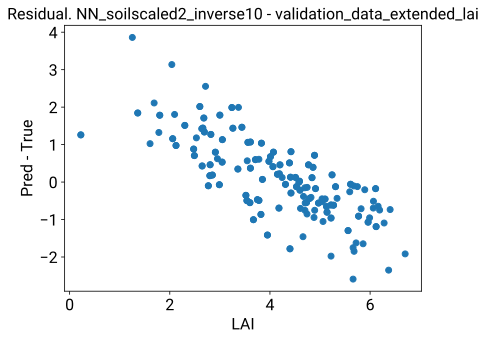

In [24]:
# Plot residuals

fig, ax = plt.subplots()
res = y_pred.squeeze() - y_test
ax.scatter(y_test, res)
ax.set_xlabel('LAI')
ax.set_ylabel('Pred - True')
ax.set_title(f'Residual. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
#plt.savefig(f'trained_models/residual_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

In [21]:
# Plot results per validation site

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

data_path = '../../results/validation_data_extended_lai.pkl'
df = pd.read_pickle(data_path)

X = df[config['Data']['train_cols']]
y = df['green_canopy_cover']
if config['Data']['normalize']:
  # Load scaler
  scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
  with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
  # Normalize
  X_test = scaler.transform(X)
  y_test = y.values
else:
  y_test = y.values


#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  #model.test_scores(y_test=y_test, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X_test)
  #model.test_scores(y_test=y_test, y_pred=y_pred)


df['preds'] = y_pred
df.reset_index(inplace=True, drop=True)

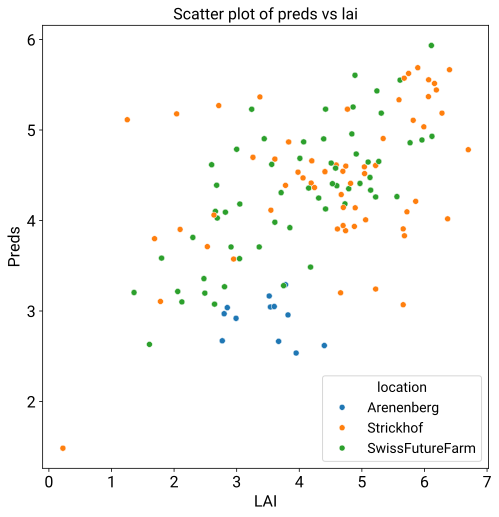

In [24]:
import seaborn as sns

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_LARGE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_LARGE)  # fontsize of the tick labels

# Assuming 'color_column' represents categorical data
plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x='lai', y='preds', hue='location')
plt.xlabel('LAI')
plt.ylabel('Preds')
plt.title('Scatter plot of preds vs lai')
plt.show()

# Test models in low LAI (<4)

In [9]:
# Load config file

config_path = "configs/config_GPR.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

In [10]:

def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y
    else:
      return X, y

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    X = concatenated_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = concatenated_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y
    else:
      return X, y

  else:
      return None


X_test, y_test = prepare_data(config)

In [11]:
# Keep only low LAI values (<4)

X_low = X_test[y_test < 4]
y_low = y_test[y_test < 4]

In [12]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

In [14]:
# Calculate RMSE
y_pred = model.predict(X_low)
print('Pred variance', y_pred.std())
model.test_scores(y_test=y_low, y_pred=y_pred)


Pred variance 2.4499784722428135
Test RMSE: 2.511113745579221


In [8]:
# Calculate RMSE
y_pred, y_std = model.predict(X_low, return_std=True)
print('GPR std', y_std.mean())
model.test_scores(y_test=y_low, y_pred=y_pred)

TypeError: NeuralNetworkRegressor.predict() got an unexpected keyword argument 'return_std'

# Test in low LAI, extended val set

In [42]:
# Load config file

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

In [43]:
def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = '../' + config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
      #X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=config['Data']['test_size'], random_state=config['Seed'])
      #print('here')
      #return X_test, y_test
    else:
      return X, y.values

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    X = concatenated_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = concatenated_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y.values
    else:
      return X, y.values

  else:
      return None

X_test, y_test = prepare_data(config)

# Keep only low LAI values (<3)
X_test = X_test[y_test < 3]
y_test = y_test[y_test < 3]

In [44]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  model.test_scores(y_test=y_test, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X_test)
  model.test_scores(y_test=y_test, y_pred=y_pred)

Test RMSE: 1.0651534657029162


(0.0, 8.0)

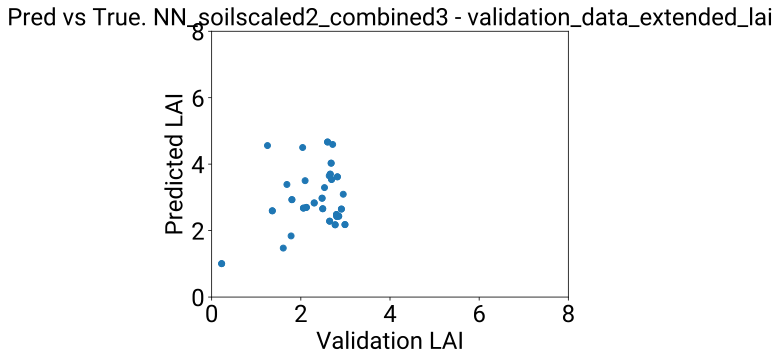

In [45]:
# Plot ypred vs ytest

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Validation LAI')
ax.set_ylabel('Predicted LAI')
ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
ax.set_xlim((0,8))
ax.set_ylim((0,8))
#plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

### For LAI < 3 compare with GCC

In [6]:
# Load config file

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

data_path = '../../results/validation_data_extended.pkl'
df = pd.read_pickle(data_path)

In [7]:
df = df[df.lai<3]
X = df[config['Data']['train_cols']]
y = df['green_canopy_cover']
if config['Data']['normalize']:
  # Load scaler
  scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
  with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
  # Normalize
  X_test = scaler.transform(X)
  y_test = y.values
else:
  y_test = y.values

In [8]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  #model.test_scores(y_test=y_test, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X_test)
  #model.test_scores(y_test=y_test, y_pred=y_pred)

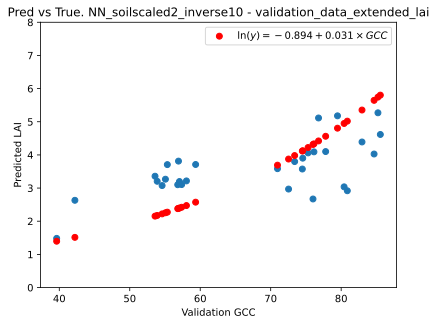

In [9]:
# Plot ypred vs ytest


fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Validation GCC')
ax.set_ylabel('Predicted LAI')
ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
#ax.set_xlim((0,8))
ax.set_ylim((0,8))
#plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

# Plot the empirical relationship found by Vilma
y_values_curve = np.exp(-0.894 + 0.031 * y_test)
ax.scatter(y_test, y_values_curve, color='red', label=r'$\ln(y) = -0.894 + 0.031 \times GCC$')
ax.legend()

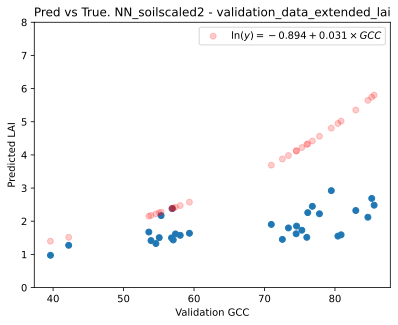

In [118]:
# Plot ypred vs ytest

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Validation GCC')
ax.set_ylabel('Predicted LAI')
ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
#ax.set_xlim((0,8))
ax.set_ylim((0,8))
#plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')


# Plot the empirical relationship found by Vilma
y_values_curve = np.exp(-0.894 + 0.031 * y_test)
ax.scatter(y_test, y_values_curve, color='red', label=r'$\ln(y) = -0.894 + 0.031 \times GCC$', alpha=0.2)
ax.legend()

# Use ExGI as a predictor for LAI
ExGI as only input to NN

In [10]:
# Load config file

config_path = "../configs/config_NN_exgi.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

data_path = '../' + config['Data']['test_data_path']

# Assuming all files in the list are pickled DataFrames
df = pd.read_pickle(data_path)
X = df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
y = df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]

X['exgi'] = 2*X['B03'] - (X['B04'] - X['B02'])
X = X[['exgi']]

if config['Data']['normalize']:
  # Load scaler
  scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
  with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
  # Normalize
  X = scaler.transform(X)

y = y.values

#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X, return_std=True)
  print('Mean test std', y_std.mean()) 
  model.test_scores(y_test=y, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X)
  model.test_scores(y_test=y, y_pred=y_pred)

Test RMSE: 1.4459651206890656


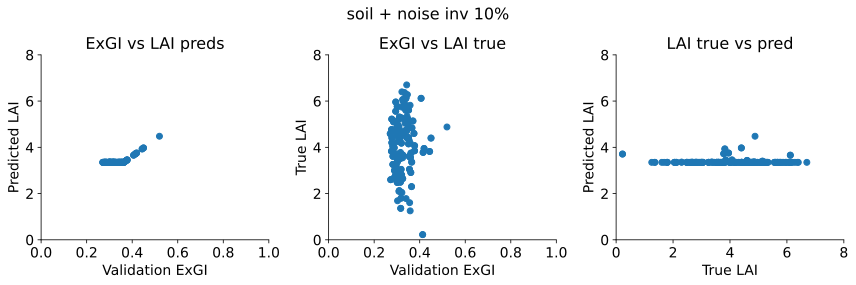

In [11]:
# Plot ypred vs ytest

plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels

fig, axs = plt.subplots(ncols=3, figsize=(12,4))

# Plot LAI prediction 
axs[0].scatter(X, y_pred)
axs[0].set_xlabel('Validation ExGI', size=14)
axs[0].set_ylabel('Predicted LAI', size=14)
#ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
axs[0].set_title(f'ExGI vs LAI preds', size=16)
axs[0].set_xlim((0,1))
axs[0].set_ylim((0,8))
# Hide the top and right spine
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)


# Plot true LAI
axs[1].scatter(X, y)
axs[1].set_xlabel('Validation ExGI', size=14)
axs[1].set_ylabel('True LAI', size=14)
#ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
axs[1].set_title(f'ExGI vs LAI true', size=16)
axs[1].set_xlim((0,1))
axs[1].set_ylim((0,8))
# Hide the top and right spine
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)


# Plot LAI pred vs true
axs[2].scatter(y, y_pred)
axs[2].set_xlabel('True LAI', size=14)
axs[2].set_ylabel('Predicted LAI', size=14)
#ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
axs[2].set_title(f'LAI true vs pred', size=16)
axs[2].set_xlim((0,8))
axs[2].set_ylim((0,8))
# Hide the top and right spine
axs[2].spines["right"].set_visible(False)
axs[2].spines["top"].set_visible(False)

plt.suptitle('soil + noise inv 10%', size=16)
plt.tight_layout()

# Use NDVI as a predictor for LAI
NDVI as only input to NN

In [12]:
# Load config file

config_path = "../configs/config_NN_exgi.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

data_path = '../' + config['Data']['test_data_path']

# Assuming all files in the list are pickled DataFrames
df = pd.read_pickle(data_path)
X = df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
y = df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]

X['ndvi'] = (X['B08'] - X['B04'])/(X['B08'] + X['B04'])
X = X[['ndvi']]

if config['Data']['normalize']:
  # Load scaler
  scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
  with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
  # Normalize
  X = scaler.transform(X)

y = y.values

X = X[y<3]
y = y[y<3]

#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X, return_std=True)
  print('Mean test std', y_std.mean()) 
  model.test_scores(y_test=y, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X)
  model.test_scores(y_test=y, y_pred=y_pred)

Test RMSE: 0.6193143523730262


In [18]:
from sklearn.metrics import r2_score
r2_score(y, y_pred)

0.02866339391000161

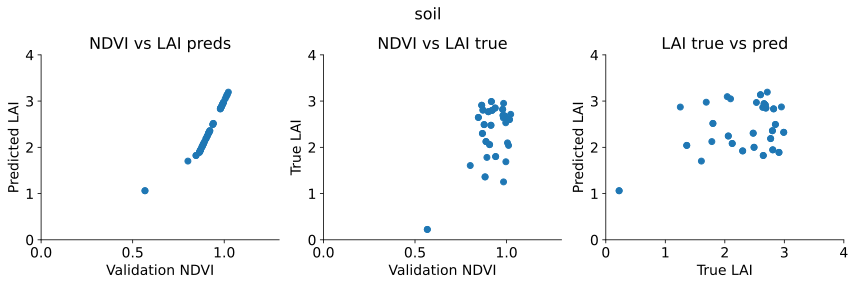

In [17]:
# Plot ypred vs ytest

plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels

fig, axs = plt.subplots(ncols=3, figsize=(12,4))

# Plot LAI prediction 
axs[0].scatter(X, y_pred)
axs[0].set_xlabel('Validation NDVI', size=14)
axs[0].set_ylabel('Predicted LAI', size=14)
#ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
axs[0].set_title(f'NDVI vs LAI preds', size=16)
axs[0].set_xlim((0,1.3))
axs[0].set_ylim((0,4))
# Hide the top and right spine
axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)


# Plot true LAI
axs[1].scatter(X, y)
axs[1].set_xlabel('Validation NDVI', size=14)
axs[1].set_ylabel('True LAI', size=14)
#ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
axs[1].set_title(f'NDVI vs LAI true', size=16)
axs[1].set_xlim((0,1.3))
axs[1].set_ylim((0,4))
# Hide the top and right spine
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)


# Plot LAI pred vs true
axs[2].scatter(y, y_pred)
axs[2].set_xlabel('True LAI', size=14)
axs[2].set_ylabel('Predicted LAI', size=14)
#ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
axs[2].set_title(f'LAI true vs pred', size=16)
axs[2].set_xlim((0,4))
axs[2].set_ylim((0,4))
# Hide the top and right spine
axs[2].spines["right"].set_visible(False)
axs[2].spines["top"].set_visible(False)

plt.suptitle('soil', size=16)
plt.tight_layout()

# Compare LAI to NDVI

In [59]:
# Load config file

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

data_path = '../../results/validation_data_extended_lai.pkl'
df = pd.read_pickle(data_path)

In [60]:
df['NDVI'] = (df['B08'] - df['B04']) / (df['B08'] + df['B04'])

In [61]:
X = df[config['Data']['train_cols']]
y = df['lai']
if config['Data']['normalize']:
  # Load scaler
  scaler_path = '../' + config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
  with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
  # Normalize
  X_test = scaler.transform(X)
  y_test = y.values
else:
  y_test = y.values

In [62]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  #model.test_scores(y_test=y_test, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X_test)
  #model.test_scores(y_test=y_test, y_pred=y_pred)

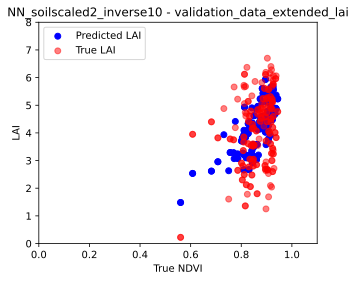

In [63]:
# Plot ypred and ytest vs NDVI

fig, ax = plt.subplots(figsize=(5, 4))

ax.scatter(df['NDVI'], y_pred, color='b', label='Predicted LAI')
ax.scatter(df['NDVI'], y_test, color='r', label='True LAI', alpha=0.5)
ax.set_xlabel('True NDVI')
ax.set_ylabel('LAI')
ax.set_title(f'{model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
ax.set_xlim((0,1.1))
ax.set_ylim((0,8))
plt.legend()
plt.show()

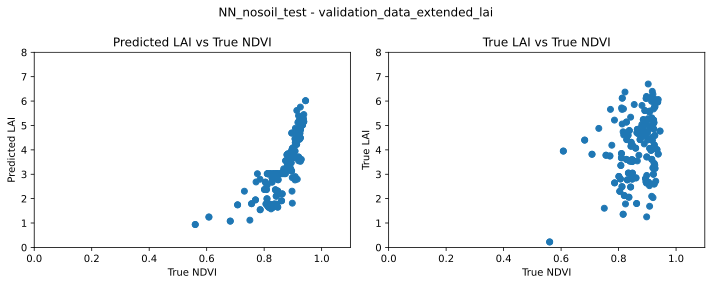

In [50]:
# Plot ypred and ytest vs NDVI

fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4))

axs[0].scatter(df['NDVI'], y_pred)
axs[0].set_xlabel('True NDVI')
axs[0].set_ylabel('Predicted LAI')
axs[0].set_title(f'Predicted LAI vs True NDVI')
axs[0].set_xlim((0,1.1))
axs[0].set_ylim((0,8))

axs[1].scatter(df['NDVI'], y_test)
axs[1].set_xlabel('True NDVI')
axs[1].set_ylabel('True LAI')
axs[1].set_title(f'True LAI vs True NDVI')
axs[1].set_xlim((0,1.1))
axs[1].set_ylim((0,8))

plt.suptitle(f'{model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
plt.tight_layout()
plt.show()

# Check feature importance of RF

In [11]:
# Load trained model
rf_model = pickle.load(open('../trained_models/RF_soilscaled2_inverse_combined20.pkl', 'rb'))

# Extract feature importances
feature_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
feature_importance = rf_model.feature_importances_

# Create a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df)

  Feature  Importance
7     B8A    0.207073
6     B08    0.168601
5     B07    0.121320
4     B06    0.084324
9     B12    0.082812
0     B02    0.071804
2     B04    0.068514
8     B11    0.066730
3     B05    0.065123
1     B03    0.063699


# Test models on fields
- download data with EOdal for some fields
- plot fields
- load model and apply
- plot predictions

In [31]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import yaml

import os
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
sys.path.insert(0, os.path.join(base_dir, "eodal"))
import eodal
from datetime import datetime
from eodal.config import get_settings
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs
from scipy.interpolate import interp2d

Settings = get_settings()
# set to False to use a local data archive
Settings.USE_STAC = True

print(f'EOdal version: {eodal.__version__}')

import pickle
import os
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent
sys.path.insert(0, str(base_dir))
from models import MODELS


EOdal version: 0.2.4


In [32]:
def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
  ) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
    interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True, cloud_classes=[3, 8, 9, 10, 11])
    return ds


def extract_s2_data(
        aoi: gpd.GeoDataFrame,
        time_start: datetime,
        time_end: datetime,
        scene_cloud_cover_threshold: float = 50,
        feature_cloud_cover_threshold: float = 80,
        spatial_resolution: int = 10
    ) -> SceneCollection:
    """
    Extracts Sentinel-2 data from the STAC SAT archive for a given area and time period.
    Scenes that are too cloudy or contain nodata (blackfill), only, are discarded.

    The processing level of the Sentinel-2 data is L2A (surface reflectance factors).

    :param parcel:
        field parcel geometry (defines the spatial extent to extract)
    :param time_start:
        start of the time period to extract
    :param end_time:
        end of the time period to extract
    :param scene_cloud_cover_threshold:
        scene-wide cloudy pixel percentage (from Sentinel-2 metadata) to filter out scenes
        with too high cloud coverage values [0-100%]
    :param feature_cloud_cover_threshold:
        cloudy pixel percentage [0-100%] on the parcel level. Only if the parcel has a
        lower percentual share of cloudy pixels (based on the scene classification layer) than
        the threshold specified, the Sentinel-2 observation is kept
    :param spatial_resolution:
        spatial resolution of the Sentinel-2 data in meters (Def: 10m)
    :param resampling_method:
        spatial resampling method for those Sentinel-2 bands not available in the target
        resolution. Nearest Neighbor by default
    :returns:
        dictionary with the list of scenes for the field parcel (`feature_scenes`), the
        DataFrame of (un)used scenes and the reason for not using plus some basic scene
        metadata (`scene_properties`)
    """
    # setup the metadata filters (cloud cover and processing level)
    metadata_filters = [
        Filter('cloudy_pixel_percentage','<', scene_cloud_cover_threshold),
        Filter('processing_level', '==', 'Level-2A')
    ]
    # setup the spatial feature for extracting data
    feature = Feature.from_geoseries(aoi.geometry)
    
    # set up mapping configs
    mapper_configs = MapperConfigs(
        collection='sentinel2-msi',
        time_start=time_start,
        time_end=time_end,
        feature=feature,
        metadata_filters=metadata_filters
    )

    # get a new mapper instance. Set sensor to `sentinel2`
    mapper = Mapper(mapper_configs)

    # query the STAC (looks for available scenes in the selected spatio-temporal range)
    mapper.query_scenes()

    # get observations (loads the actual Sentinel2 scenes)
    # the data is extract for the extent of the parcel
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,            # this tells the mapper how to read and load the data (i.e., Sentinel-2 scenes)
        'scene_constructor_kwargs': {'band_selection': ['B01','B02','B03', 'B04', 'B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12', 'SCL']},   # here you could specify which bands to read
        'scene_modifier': preprocess_sentinel2_scenes,       # this tells the mapper about (optional) pre-processing of the loaded scenes (must be a callable)
        'scene_modifier_kwargs': {'target_resolution': spatial_resolution}   # here, you have to specify the value of the arguments the `scene_modifier` requires
    }
    mapper.load_scenes(scene_kwargs=scene_kwargs)

    # loop over available Sentinel-2 scenes stored in mapper.data as a EOdal SceneCollection and check
    # for no-data. These scenes will be removed from the SceneCollection
    scenes_to_del = []
    mapper.metadata['scene_used'] = 'yes'
    mapper.metadata['n_bare'] = [0]*len(mapper.metadata)

    if mapper.data is not None:
        for scene_id, scene in mapper.data:

            # check if scene is blackfilled (nodata); if yes continue
            if scene.is_blackfilled:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [blackfill]'
                continue

            # check cloud coverage (including shadows and snow) of the field parcel
            feature_cloud_cover = scene.get_cloudy_pixel_percentage(cloud_classes=[3, 8, 9, 10, 11])

            # if the scene is too cloudy, we skip it
            if feature_cloud_cover > feature_cloud_cover_threshold:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [clouds]'
                continue
     
        
        # delete scenes too cloudy or containing only no-data
        for scene_id in scenes_to_del:
            del mapper.data[scene_id]
        # Keep only metadata for corresponding scenes
        dates_to_del = [scene_id.date() for scene_id in scenes_to_del]
        mapper.metadata = mapper.metadata[~mapper.metadata['sensing_date'].isin(dates_to_del)]
    
    return mapper


In [33]:
# Load field bounds
shp_path = '../../data/Witzwil.shp'
shp_gdf = gpd.read_file(shp_path)

# Dowload images for fields
res_fields = extract_s2_data(
  aoi=shp_gdf.dissolve(),
  time_start=datetime(2021,6,1),
  time_end=datetime(2021,6,30)
)

2024-04-05 16:38:13,229 eodal        INFO     Starting extraction of sentinel2 scenes
2024-04-05 16:38:46,516 eodal        INFO     Finished extraction of sentinel2 scenes


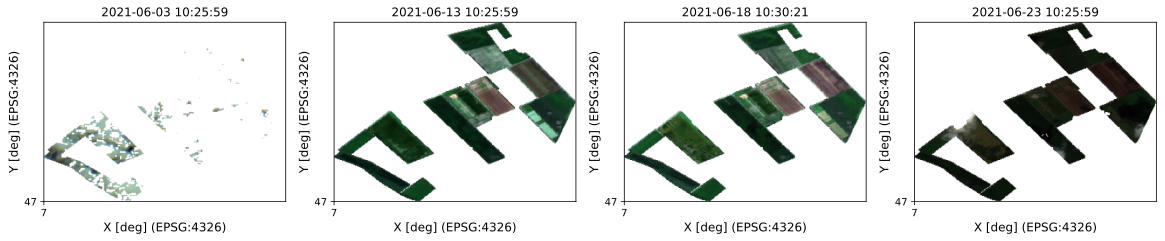

In [4]:
# Plot fields

scoll = res_fields.data
n_scenes = len(scoll)
f, axes = plt.subplots(1,ncols=n_scenes,figsize=(20,8))
i = 0
for scene_id, scene in scoll:
    scene.plot_multiple_bands(
        band_selection=['red', 'green' ,'blue'],
        ax=axes[i]
    )
    axes[i].set_title(scene_id)
    i += 1
    #axes[0].set_ylim((5253900, 5255600))
    #axes[0].set_xlim((475793, 476675))
  

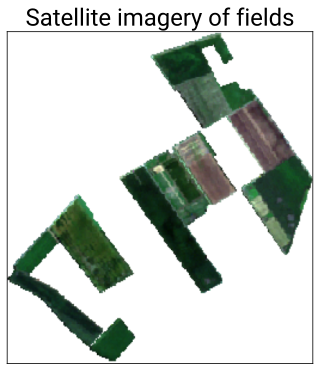

In [40]:
# Plot single scene

# Define font sizes
SIZE_DEFAULT = 20
SIZE_LARGE = 24
plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_LARGE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_LARGE)  # fontsize of the tick labels

scoll = res_fields.data
f, ax = plt.subplots(figsize=(8,6))
i = 0
for scene_id, scene in scoll:
    if i == 2:
      scene.plot_multiple_bands(
          band_selection=['red', 'green' ,'blue'],
          ax=ax
      )
      #ax.set_title(scene_id)
      # Remove x and y ticks and labels
      plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
      ax.set_xlabel('')
      ax.set_ylabel('')
      ax.set_title('Satellite imagery of fields')
    i += 1

# Get x and y tick positions and labels
x_tick_positions = ax.get_xticks()
x_tick_labels = ax.get_xticklabels()
y_tick_positions = ax.get_yticks()
y_tick_labels = ax.get_yticklabels()



In [35]:
def scene_to_array(sc,tx,ty, band_list):
    """
    Generate an numpy array (image stack) from a given Eodal RasterCollection.
    The scenes are resampled on a costant coordinate grid allowing pixel analysis.
    Missing data location are marked as nans.
    
    Parameters
    ----------
    sc : Eodal SceneCollection
        The given Scene Collection generated from Eodal
    tx : Float Vector
        x coordinate vector for the resample grid.
    ty : Float Vector
        x coordinate vector for the resample grid.
    band_list: list
        List of band names to keep.

    Returns
    -------
    im : float 3D numpy array.
        Array containing the stack of all bands in a scene.
        3 dimensions: [x, y, bands]

    """
    
    im_size = [len(ty),len(tx)] # image size
    im = np.empty(np.hstack([im_size,len(band_list)])) # preallocate matrix
    i = 0

    for idx, band_iterator in enumerate(scene):

        if band_iterator[0] in band_list:

            #original grid coordinates
            band = band_iterator[1]
            Gv = np.copy(band.values.data)
            ny,nx = np.shape(Gv)
            vx = band.coordinates['x']
            vy = band.coordinates['y']
        
            # create interpolator
            Gv_no_nans = Gv.copy()
            Gv_no_nans[np.isnan(Gv)] = 0
            f = interp2d(vx,vy,Gv_no_nans,kind='linear',fill_value=0)
            
            # interpolate band on the target grid
            Tv = np.flipud(f(tx,ty))
            
            
            # assign interpolated band [i = scene , b = band]
            im[:,:,i] = Tv.copy()
            i += 1
    
    return im

In [36]:
# Get data for one of the dates
date_search = datetime(2021,6,18).date()
scoll_idx = [i for i, _ in scoll if i.date()==date_search][0]
scene = scoll.__getitem__(scoll_idx)
scene.reproject(inplace=True, target_crs=2056)

res = 10
lef = shp_gdf.total_bounds[0]
rig = shp_gdf.total_bounds[2]
bot = shp_gdf.total_bounds[1]
top = shp_gdf.total_bounds[3]
tx = np.arange(lef, rig, res)
ty = np.arange(top, bot, -res)
bands = ['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12']

arr = scene_to_array(scoll,tx,ty,bands)

In [37]:
# Predict for each pixel

config_path = "../configs/config_NN.yaml"
with open(config_path, "r") as config_file:
    config = yaml.safe_load(config_file)

#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = '../' + config['Model'].pop('save_path')
with open(model_filename, 'rb') as f:
  model = pickle.load(f)
# Open corresponding scaler to normalise data
with open(model_filename.split('.pkl')[0] + '_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

#############################################
# PREDICT

# Normalise the data
arr_reshaped = arr.reshape(-1, arr.shape[-1]) # Reshape the image to  (width * height, bands)
arr_reshaped_norm = scaler.transform(arr_reshaped)
arr_norm = arr_reshaped_norm.reshape(arr.shape) # Reshape back to original
arr_norm[arr==0] = 0

preds = np.zeros((arr.shape[0], arr.shape[1]))

for i in range(arr_norm.shape[0]): 
    for j in range(arr_norm.shape[1]): 

        pixel_features = arr_norm[i, j, :]
        if pixel_features.sum() == 0:
            preds[i, j] = 0
            continue
        else:
            pixel_features = pixel_features.reshape(1, -1)
            lai = model.predict(pixel_features)
            preds[i, j] = lai

preds[preds<=0] = np.nan

In [38]:
vx = scene['B01'].coordinates['x']
vy = scene['B01'].coordinates['y']

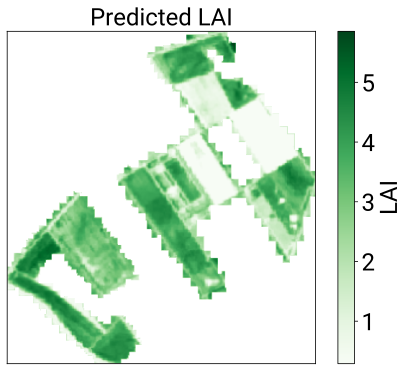

In [39]:
# Define font sizes
SIZE_DEFAULT = 20
SIZE_LARGE = 24
plt.rc("font", family="Roboto")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_LARGE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_LARGE)  # fontsize of the tick labels


# Plot the predictions array
plt.figure(figsize=(8, 6))
plt.imshow(preds, cmap='Greens')  
cbar = plt.colorbar()
cbar.set_label('LAI')
plt.title('Predicted LAI')

# Remove x and y ticks and labels
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

# Remove top and right border of the frame
#plt.gca().spines['top'].set_visible(False)
#plt.gca().spines['right'].set_visible(False)

plt.show()